# spinal_wide_noisy.ipynb

Duplicate of `spinal_base_wide` (e.g. 12 units in SPF and M) with noisy C population.

In [1]:
%cd ../..
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
%load_ext Cython

In [3]:
%%cython
from draculab import *

In [4]:
##################################
####### Create the network #######
##################################

# First the network object, the plant, the list of coordinates
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 10 }
P_params = {'type' : plant_models.bouncy_planar_arm,
            'mass1' : 1.,
            'mass2' : .8,
            'smin' : -0.4,
            'p1' : (-0.01, 0.04),
            'p2' : (0.29, 0.03),
            'p3' : (0., 0.05),
            'p5' : (0.01, -0.05),
            'p10': (0.29, 0.03),
            'init_q1' : np.pi/4., #0.53496133, 
            'init_q2' : np.pi/2., #0.89566479, 
            'init_q1p' : 0.,
            'init_q2p' : 0.,
            'g' : 0.,
            'mu1' : .5,
            'mu2' : .5,
            'l_torque' : 0.01,
            'l_visco' : 0.05,
            'm_gain' : 30.,
            'l_gain' : 1.,
            'v_gain' : 5.,
            'spring' : 1.,
            'tau' : 0.1 } # ficticious time constant used in create_freqs_steps
net = network(net_params)
P = net.create(1, P_params)
arm = net.plants[P]

# We organize the spinal connections through 4 types of symmetric relations
# these lists are used to set intraspinal connections and test connection matrices
antagonists = [(0,3), (1,2), (4,5)]
part_antag = [(0,2),(0,5), (3,4), (1,3)]
synergists = [(0,1), (0,4), (2,3), (3,5)]
part_syne = [(1,4), (2,5)]
self_conn = [(x,x) for x in range(6)]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# UNIT PARAMETER DICTIONARIES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
par_heter = 0.05 # range of heterogeneity as a fraction of the original value
#randz1 = lambda : (1. + par_heter*(np.random.rand()-0.5))
randz6 = lambda : (1. + par_heter*(np.random.rand(6)-0.5))
randz12 = lambda : (1. + par_heter*(np.random.rand(12)-0.5))
randz18 = lambda : (1. + par_heter*(np.random.rand(18)-0.5))

SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 1., #np.array([.3, .2, 1.7, 2.5, 1.5, 1.5]), #1.3 * randz6(),
             'slope' : 3., #np.array([2.3, 2.5, .6, 12., 3.5, 5.0]),   #2.5 * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.03 * randz6() } 
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'tau_fast' : 0.02,
             'tau_mid' : 0.1,
             'function' : lambda t: None }
SP_CHG_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.3,
              'slope' : 9.,
              'init_val' : 0.1,
              'tau' : 0.01 }
SPF_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.4 * randz12(),
              'slope' : 6. * randz12(),
              'init_val' : 0.3 * randz12(),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.02 * randz12() }
M_params = {'type' : unit_types.gated_out_norm_am_sig,
            'thresh' : 0. * randz12(),
            'slope' : 3. * randz12(),
            'init_val' : 0.2 * randz12(),
            'delay' : 0.2,
            'tau_fast': 0.01,
            'tau_mid': 0.05,
            'tau_slow' : 2.,
            'tau' : 0.01 * randz12(),
            'p0_inp' : 0.0,
            'des_out_w_abs_sum' : 1. }
CE_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
             'integ_meth' : 'euler_maru',
             'mu' : 0.,
             'sigma' : 0.1,
             'thresh' : 0.1 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.02 * randz6(),
             'tau_fast': 0.01,
             'tau_mid' : 0.05,
             'tau_slow' : 6.,
             'custom_inp_del' : 15,
             'integ_amp' : .5,
             'adapt_amp' : 8.,
             'delay' : 0.2,
             'des_out_w_abs_sum' : 1. }
CI_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
             'integ_meth' : 'euler_maru',
             'mu' : 0.,
             'sigma' : 0.1,
             'thresh' : .5 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.5 * randz6(), #0.02 * randz6(),
             'tau_fast': 0.01,
             'tau_mid' : 0.05,
             'tau_slow' : 6.,
             'custom_inp_del' : 15,
             'integ_amp' : .5,
             'adapt_amp' : 8.,
             'delay' : 0.2,
             'des_out_w_abs_sum' : 1. }
AL_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.3 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.1 * randz6(),
             'tau' : 0.02 * randz6() }
AF_params = {'type' : unit_types.logarithmic,
             'init_val' : 0.5 * randz18(),
             'tau' : 0.02 * randz18(),
             'tau_fast': 0.005,
             'delay' : 0.1,
             'thresh' : np.array([-0.1, -0.1, 2.8,
                                  -0.1, -0.1, 2.8,
                                  -0.1, -0.1, 2.8,
                                  -0.1, -0.1, 2.8,
                                  -0.1, -0.1, 2.8,
                                  -0.1, -0.1, 2.8]) } # length afferents report (l-l0)/l0

ACT_params = {'type' : unit_types.act,
              'tau_u' : 10.,
              'gamma' : 1.5,
              'g' : 3.,
              'theta' : 2.5,
              'tau_slow' : 5.,
              'y_min' : 0.4,
              'rst_thr' : 0.1,
              'init_val' : 0. }
spf_sum_min = .4 # value where no corrections are needed anymore
y_min = 1./(1. + np.exp(-ACT_params['g']*(spf_sum_min - ACT_params['theta'])))
ACT_params['y_min'] = y_min

track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONNECTION DICTIONARIES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SF, SP to SPF
SFe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
# SP to SP_CHG
SP__SP_CHG_conn = {'rule' : 'all_to_all',
                    'delay' : 0.01}
SP__SP_CHG_syn = {'type' : synapse_types.chg,
                  'init_w' : 0.,
                  'lrate' : 20. }
# SP_CHG to CE, CI
SP_CHG__CE_conn = {'rule' : "all_to_all",
                  'delay' : 0.02 }
SP_CHG__CE_syn = {'type' : synapse_types.static,
                  'inp_ports' : 3,
                  'init_w' : 1. }
SP_CHG__CI_conn = {'rule' : "all_to_all",
                   'delay' : 0.02 }
SP_CHG__CI_syn = {'type' : synapse_types.static,
                  'inp_ports' : 3,
                  'init_w' : 1. }
# SP_CHG to ACT
SP_CHG__ACT_conn = {'rule' : "all_to_all",
                   'delay' : 0.02 }
SP_CHG__ACT_syn = {'type' : synapse_types.static,
                  'inp_ports' : 1,
                  'init_w' : 1. }
# SP_CHG to M
SP_CHG__M_conn = {'rule' : "all_to_all",
                  'delay' : 0.02 }
SP_CHG__M_syn = {'type' : synapse_types.static,
                  'inp_ports' : 2,
                  'init_w' : 1. }
# SPF to M
SPF__M_conn = {'rule': 'one_to_one',
               'delay': 0.01 }
SPF__M_syn = {'type' : synapse_types.static, #synapse_types.inp_corr,
              'inp_ports' : 1,
              'lrate' : 0.,
              'input_type' : 'error', # if using inp_corr
              'init_w' : 2. }
# SPF to ACT
SPF__ACT_conn = {'rule' : "all_to_all",
                 'delay' : 0.02 }
SPF__ACT_syn = {'type' : synapse_types.static,
                'inp_ports' : 0,
                'init_w' : 1. }
# ACT to CE,CI
ACT__CE_conn = {'rule' : "all_to_all",
                'delay' : 0.02 } 
ACT__CE_syn = {'type' : synapse_types.static,
               'inp_ports' : 4,
               'init_w' : 1. }
ACT__CI_conn = {'rule' : "all_to_all",
                'delay' : 0.02 } 
ACT__CI_syn = {'type' : synapse_types.static,
               'inp_ports' : 4,
               'init_w' : 1. }
# motor to spinal connections
# creating a test matrix <<< THIS CODE IS NOT UPDATED FOR 12 UNITS IN M
# M_CE = np.zeros((6, 6))
# M_CI = np.zeros((6, 6))
# for x in range(6):
#     M_CI[x,x] = 1.
#     for pair in antagonists:
#         if x == pair[0]:
#             M_CE[x, pair[1]] = 1.
#             M_CE[pair[1], x] = 1.
#     for pair in part_antag:
#         if x == pair[0]:
#             M_CE[x, pair[1]] = 0.4
#             M_CE[pair[1], x] = 0.4
#     for pair in synergists:
#         if x == pair[0]:
#             M_CI[x, pair[1]] = 0.5
#             M_CI[pair[1], x] = 0.5
#     for pair in part_syne:
#         if x == pair[0]:
#             M_CI[x, pair[1]] = 0.3
#             M_CI[pair[1], x] = 0.3
M_CE = 0.4*(np.random.random((12,6)) - 0.5) # random initial connections!!!!!!!!!!!!!!!!!!!
M_CI = 0.4*(np.random.random((12,6)) - 0.5) # random initial connections!!!!!!!!!!!!!!!!!!!
M__CE_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CE_syn = {'type' : synapse_types.gated_rga,
             'inp_ports' : 0,
             'lrate' : 50.,
             'w_sum' : 3.,
             'init_w' : M_CE.flatten() }
M__CI_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CI_syn = {'type' : synapse_types.gated_rga,
             'inp_ports' : 0,
             'lrate' : 50,
             'w_sum' : 3.,
             'init_w' : M_CI.flatten() }
# interneurons to alpha motoneurons
CE__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__AL_syn = {'type' : synapse_types.static,
              'init_w' : [1., 1., 1., 1., 1., 1.] }
CI__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__AL_syn = {'type' : synapse_types.static,
              'init_w' : -1. }
# alpha motoneurons to plant
AL__P_conn = {'inp_ports' : list(range(0,18,3)),
             'delays': 0.01 }
AL__P_syn = {'type': synapse_types.static,
            'init_w' : 1. } #[1., 1., 1.7, 1.2, 1., 2.5] } 
# length afferents to sensory
AF__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
AF__SF_syn = {'type' : synapse_types.static,
             'init_w' : 3. } # [4., 3., 3., 5., 3., 3.] }
# afferents to motor
## Creating a test matrix << SECTION NOT ADAPTED TO 12 UNITS IN M
# AF_M = np.zeros((6, 18))
# def a_m_connect(A_M, pair_list, weights):
#     for pair in pair_list:
#         A_M[pair[0], 3*pair[1]] = weights[0]
#         A_M[pair[0], 3*pair[1]+1] = weights[1]
#         A_M[pair[0], 3*pair[1]+2] = weights[2]
#         A_M[pair[1], 3*pair[0]] = weights[0]
#         A_M[pair[1], 3*pair[0]+1] = weights[1]
#         A_M[pair[1], 3*pair[0]+2] = weights[2]        
# a_m_connect(AF_M, self_conn, (0., -0.4, 0.4))
# a_m_connect(AF_M, synergists, (0., -0.2, 0.2))
# a_m_connect(AF_M, part_syne, (0., 0., 0.))
# a_m_connect(AF_M, part_antag, (0., 0.2, -0.2))
# a_m_connect(AF_M, antagonists, (0., 0.4, -0.4))
# AF_M = AF_M.transpose()
AF_M = 0.2*(np.random.random((18,12)) - 0.5) # random initial connections!!!!!!!!!!!!!!!!!!!
f = 1. # going estimate the extra delay of error inputs wrt afferent inputs at M
w = 2.*np.pi*f
sf_del = np.arctan(np.mean(SF_params['tau'])*w)/w
spf_del = np.arctan(np.mean(SPF_params['tau'])*w)/w
delay = spf_del + sf_del + AF__SF_conn['delay'] + SFe__SPF_conn['delay']
steps = int(round(delay/net.min_delay))
AF_params['delay'] = AF_params['delay'] + net_params['min_delay'] * (np.ceil(delay/net_params['min_delay']) + 1)
AF__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
AF__M_syn = {'type' : synapse_types.gated_inp_sel,
            'aff_port' : 0,
            'error_port' : 1,
            'normalize' : False,
            'w_sum' : 3.,
            'inp_ports' : 0, # afferent for out_norm_am_sig
            'input_type' : 'pred', # if using inp_corr
            'lrate' : 1.,
            'extra_steps' : steps,
            'init_w' : AF_M.flatten() } #.1 }
# afferents to spinal
AF__CE_conn = {'rule' : 'all_to_all',
               'delay' : 0.02 }
AF__CE_syn = {'type' : synapse_types.gated_inp_sel,
              'aff_port' : 2,
              'inp_ports' : 2,
              'error_port' : 0,
              'normalize' : True,
              'w_sum' : 5.,
              'lrate' : 5.,
              'extra_steps' : 1,
              'init_w' : 0.05 }
AF__CI_conn = {'rule' : 'all_to_all',
               'delay' : 0.02 }
AF__CI_syn = {'type' : synapse_types.gated_inp_sel,
              'aff_port' : 2,
              'inp_ports' : 2,
              'error_port' : 0,
              'normalize' : True,
              'w_sum' : 5.,
              'lrate' : 5.,
              'extra_steps' : 1,
              'init_w' : 0.05 }
# plant to afferents
bool_aff = [False] * 4 + [False, True, True, True] * 6
idx_aff = np.arange(28)[bool_aff] # indexes for afferent output in the arm
P__AF_conn = {'port_map' : [[(p,0)] for p in idx_aff],
             'delays' : 0.02 }
P__AF_syn = {'type' : synapse_types.static,
            'init_w' : [ 20., 5., .3, # 0
                        8.7,  5., .3,
                        2.5,  5., .3, # 2
                        17.,  5., .3,
                        2.8,  5., .3, # 4
                        14.4, 5., .3 ] }
# lateral connections in C
CE__CI_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__CE_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__CI_syn = {'type' : synapse_types.static,
              'inp_ports' : 1,
              'init_w' : .4 }
CI__CE_syn = {'type' : synapse_types.corr_inh, #static, #corr_inh,
              'inp_ports' : 1,
              'lrate' : .2,
              'des_act' : 0.1,
              'init_w' : -1.5 }
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.015 }
C__C_syn_antag = {'type' : synapse_types.bcm, #corr_inh,
                  'inp_ports': 1,
                  'init_w' : 1.,
                  'lrate' : 1.,
                  'des_act' : 0.5 }
C__C_syn_p_antag = {'type' : synapse_types.bcm,
                  'inp_ports': 1,
                  'init_w' : .4,
                  'lrate' : 1.,
                  'des_act' : 0.5 }
C__C_syn_syne = {'type' : synapse_types.static,
                 'inp_ports': 1,
                 'lrate' : 1.,
                 'init_w' : 1. }
C__C_syn_p_syne = {'type' : synapse_types.static,
                   'inp_ports': 1,
                   'lrate' : 1.,
                   'init_w' : 0.4 }

def approx_del(f):
    """ Returns an estimate fo the optimal delay for rga learning.
    
        We assume that the important loop for the learning rule in the C units
        is the one going through C-AL-P-AF-M-C.
        We also assume the delays to/from CI are the same as the ones for CE.
        
        Args:
            f : oscillation frequency of E-I pair in C, in Hertz
        Returns:
            2-tuple : (time_del, del_steps)
            time_del : A float with the time delay.
            del_steps : time delay as integer number of min_del steps.
    """
    w = 2.*np.pi*f
    al_del = np.arctan(np.mean(AL_params['tau'])*w)/w
    p_del = np.arctan(np.mean(P_params['tau'])*w)/w
    af_del = np.arctan(np.mean(AF_params['tau'])*w)/w
    m_del = np.arctan(np.mean(M_params['tau'])*w)/w
    D = [CE__AL_conn['delay'], AL__P_conn['delays'], np.mean(P__AF_conn['delays']),
         AF__M_conn['delay'], M__CE_conn['delay'] ]
    time_del = al_del + p_del + af_del + m_del + sum(D)
    del_steps = int(np.ceil(time_del/net_params['min_delay']))
    time_del = del_steps*net_params['min_delay']
    del_steps -= 1 # because this is an index, and indexes start at 0
    return time_del, del_steps

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CREATING UNITS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SF = net.create(6, SF_params)
SP = net.create(6, SP_params)
SPF = net.create(12, SPF_params)
AL = net.create(6, AL_params)
AF = net.create(18, AF_params)
SP_CHG = net.create(1, SP_CHG_params)
# Approximating the delays for the rga rule
time_del, del_steps = approx_del(1.1) #0.65 is approximate CE/CI frequency observed in simulations
CE_params['delay'] = time_del
CI_params['delay'] = time_del
M_params['delay'] = time_del
CE_params['custom_inp_del'] = del_steps
CI_params['custom_inp_del'] = del_steps
CE = net.create(6, CE_params)
CI = net.create(6, CI_params)
M = net.create(12, M_params)
ACT = net.create(1, ACT_params)

# SET THE PATTERNS IN SP
t_pres = 30. # number of seconds to hold each set of target lengths
# list with hand coordinates [x,y] (meters)
hand_coords = [[0.3, 0.45], 
               [0.35, 0.4],
               [0.4, 0.35],
               [0.35, 0.3],
               [0.3, 0.25],
               [0.25, 0.3],
               [0.2, 0.35],
               [0.25, 0.4]]
               #[-0.1, 0.3],
               #[-0.1, 0.35]] # extra coordinate "for fun"
# list with muscle lengths corresponding to the hand coordinates
m_lengths = []
for coord in hand_coords:
    m_lengths.append(arm.coords_to_lengths(coord))
m_lengths = np.array(m_lengths)
# We need to translate these lengths to corresponding SF activity levels.
# For that it is necessary to recreate all their transformations
# The first transformation is from length to Ia activity in the muscle object
l = np.array([net.plants[P].muscles[i].l0 for i in range(6)]) # resting lengths
m_lengths = P_params['l_gain']*(m_lengths - l) / l
# Next transformation is through the logarithmic afferent units
P__AF_ws = np.array([P__AF_syn['init_w'][i] for i in range(0,18,3)])
l_arg = (P__AF_ws*m_lengths) - np.array(AF_params['thresh'][0:16:3])
l_affs = np.log(1. + np.maximum(0., l_arg))
# Next is from AF to SF
sf_arg = AF__SF_syn['init_w']*l_affs
sf_preds = 1./ (1. + np.exp(-SF_params['slope']*(sf_arg - SF_params['thresh'])))

m_idxs = np.random.randint(len(hand_coords), size=1000) # index of target lengths
#m_idxs[0] = 0 # for testing

def make_fun(idx):
    """ create a function for the SP unit with index 'idx'. """
    return lambda t: sf_preds[m_idxs[int(np.floor(t/t_pres))]][idx]

for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

# tracking units
M_CE_track = net.create(len(M), track_params) # to track weights from M to CE
#M_CI_track = net.create(len(M), track_params) # to track weights from M to CI
AF_M0_track = net.create(18, track_params) # to track weights from AF to M0

xp_track = net.create(1, track_params) # del_avg_inp_deriv of C0 at port 1
up_track = net.create(1, track_params) # to track the derivative of CE0
sp_track = net.create(1, track_params) # avg_inp_deriv_mp for CE0 at port 0
spj_track = net.create(1, track_params) # input derivative for MX--CE0

ipx_track = net.create(12, track_params) # x coordinates of insertion points
ipy_track = net.create(12, track_params) # y coordinates of insertion points

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONNECTING
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# from M to CE
net.connect(M, CE, M__CE_conn, M__CE_syn)
# from M to CI
net.connect(M, CI, M__CI_conn, M__CI_syn)
# from CE to AL
net.connect(CE, AL, CE__AL_conn, CE__AL_syn)
# from CI to AL
net.connect(CI, AL, CI__AL_conn, CI__AL_syn)
# from AL to P
net.set_plant_inputs(AL, P, AL__P_conn, AL__P_syn)
# from P to AF
net.set_plant_outputs(P, AF, P__AF_conn, P__AF_syn)
# from AF to SF. Only the length afferents are selected
AF_len = [AF[i] for i in range(0,18,3)]
net.connect(AF_len, SF, AF__SF_conn, AF__SF_syn)
# from AF to M
net.connect(AF, M, AF__M_conn, AF__M_syn) # should be made before SPF-->M
# from AF to CE,CI
net.connect(AF, CE, AF__CE_conn, AF__CE_syn)
net.connect(AF, CI, AF__CI_conn, AF__CI_syn)
# from SF, SP to SPF
net.connect(SF, SPF[0:6], SFe__SPF_conn, SFe__SPF_syn)
net.connect(SF, SPF[6:12], SFi__SPF_conn, SFi__SPF_syn) 
net.connect(SP, SPF[0:6], SPi__SPF_conn, SPi__SPF_syn)
net.connect(SP, SPF[6:12], SPe__SPF_conn, SPe__SPF_syn)
# from SPF to M
net.connect(SPF, M, SPF__M_conn, SPF__M_syn) # should be after A-->M
# from SPF to ACT
net.connect(SPF, ACT, SPF__ACT_conn, SPF__ACT_syn)
# from SP to SP_CHG
net.connect(SP, SP_CHG, SP__SP_CHG_conn, SP__SP_CHG_syn)
# from SP_CHG to CE,CI
net.connect(SP_CHG, CE, SP_CHG__CE_conn, SP_CHG__CE_syn)
net.connect(SP_CHG, CI, SP_CHG__CI_conn, SP_CHG__CI_syn)
# from SP_CHG to M
net.connect(SP_CHG, M, SP_CHG__M_conn, SP_CHG__M_syn)
# from SP_CHG to ACT
net.connect(SP_CHG, ACT, SP_CHG__ACT_conn, SP_CHG__ACT_syn)
# from ACT to CE, CI
net.connect(ACT, CE, ACT__CE_conn, ACT__CE_syn)
net.connect(ACT, CI, ACT__CI_conn, ACT__CI_syn)
# intraspinal connections 
# from CE to CI, and CI to CE
net.connect(CE, CI, CE__CI_conn, CE__CI_syn)
net.connect(CI, CE, CI__CE_conn, CI__CE_syn)
# agonists and antagonists
EE_syn_dicts = [C__C_syn_syne, C__C_syn_p_syne]
EI_syn_dicts = [C__C_syn_antag, C__C_syn_p_antag]
EE_pair_lists = [synergists, part_syne] # order should match list above
EI_pair_lists = [antagonists, part_antag] # order should match list above
for pair_list, syn_dict in zip(EE_pair_lists, EE_syn_dicts):
    firsts = [CE[p[0]] for p in pair_list]
    seconds = [CE[p[1]] for p in pair_list]
    net.connect(firsts, seconds, C__C_conn, syn_dict)
    net.connect(seconds, firsts, C__C_conn, syn_dict)
for pair_list, syn_dict in zip(EI_pair_lists, EI_syn_dicts):
    firsts = [CE[p[0]] for p in pair_list] + [CE[p[1]] for p in pair_list]
    seconds = [CI[p[1]] for p in pair_list] + [CI[p[0]] for p in pair_list]
    net.connect(firsts, seconds, C__C_conn, syn_dict)

# SETTING UP WEIGHT TRACKING -- depends on the order of statements above!!!!!!
# This assumes the first connections to C are M-->C
def M_CE0_fun(idx):
    """ Creates a function to track a weight from M to CE0. """
    return lambda t: net.syns[CE[0]][idx].w
for idx in range(len(M)):
    net.units[M_CE_track[idx]].set_function(M_CE0_fun(idx))
# This assumes the first connections to M are AF-->M    
def AF_M0_fun(idx):
    """ Creates a function to track a weight from AF to M0. """
    return lambda t: net.syns[M[0]][idx].w
for idx in range(18):
    net.units[AF_M0_track[idx]].set_function(AF_M0_fun(idx))

# SETTING TRACKING OF PLASTICITY FACTORS FOR MX-->CE0
X = 0 # index of the M unit we'll monitor

net.units[xp_track[0]].set_function(lambda t: net.units[CE[0]].del_avg_inp_deriv_mp[1])
po_de = net.units[CE[0]].custom_inp_del
net.units[up_track[0]].set_function(lambda t: net.units[CE[0]].get_lpf_fast(po_de) - 
                                    net.units[CE[0]].get_lpf_mid(po_de))
net.units[sp_track[0]].set_function(lambda t: net.units[CE[0]].avg_inp_deriv_mp[0])
ds = net.syns[CE[0]][0].delay_steps
net.units[spj_track[0]].set_function(lambda t: net.units[M[X]].get_lpf_fast(ds) - 
                                     net.units[M[X]].get_lpf_mid(ds))
# TRACKING OF INSERTION POINTS (for the arm animation)
# make the source units track the tensions
def create_xtracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][0]
def create_ytracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][1]
for idx, uid in enumerate(ipx_track):
    net.units[uid].set_function(create_xtracker(P, idx))
for idx, uid in enumerate(ipy_track):
    net.units[uid].set_function(create_ytracker(P, idx))

In [26]:
# removing feedback to compare with Fink et al.
for uid in CE+CI:
    syn_list = net.syns[uid]
    for syn in syn_list:
        if syn.preID in AF:
            #syn.w = 0.
            #syn.alpha = 1.
            #syn.normalize = False
            syn.w_sum = 10.

* Set weight to mass1=1, mass2=0.8 . The reaching is good, but there are still systematic endpoint errors. These may be due to the dynamic range of the afferents, but there's a chance that they can be reduced by forcing further plasticity. I thus:
* Reduced the ACT_params['tau_u'] value from 7 to 3, and the targets are now changed each 30 seconds. Some reaching took place, but after 2800 seconds the arm was not yet converging, and error/wandering arm could shoot up at any moment.
* Set 'p0_inp' from 0.1 to 0.05. Bit better, but no convergence yet.
* Set p0_inp to 0. It managed to reach without activating adaptation (2 activations in 17 reaches) despite the fast accumulation.

This last point is a big achievement. Let's see if it can do it **without** AF__C short loop reflexes.
* Commentd out AF__C connections. Learning was faster! (~300 s).
* Reintroduced the AF__C connections, but this time I set their weights to zero and froze the learning (syn.w=0, syn.alpha=0 for every AF__C synapse). Learning took longer, and wasn't as effective. Could it be the initial conditions? In any case, I set syn.alpha=1 for all AF__C synapses, ans syn.normalize=True. It seems the error was reduced at first, but noo, it came back, and setting syn.normalize=False froze the arm's movement. Upon inspection, the AF__C weights could get really large.

So the short-loop afferent connections aren't necessary, and not even beneficial yet. 
* Let's introduce the new dynamic ranges from spinal_test-Copy3.
    * Changed SF_params['thresh'] from 0.9 to 1.5, 
    * AF_params['thresh'] from -.1 to 0 for velocity afferents, from 2.5 to 3 for tension afferents
    * P__AF_syn['init_w'] from 3 to 5 for velocity afferents.
    
    I get the impression that the endpoint errors look bigger now.
---

* Testing a dynamic range based on rest lengths.
    * Setting AF_params['thresh'] to 0. for all lengths, and -0.1 for all velocities.
    * Set P__AF_syn['init_w'] so the maximum length for the 8 targets would produce roughly 0.5 activation in AF. This meant going from \[20, 3.9, 3.9, 18.5, 4.4, 5.7 \] to \[21, 8.7, 2.5, 17, 2.8, 14.4 \]
    * AF__SF_syn['init_w'] from \[4., 3., 3., 5., 3., 3.\] to 3. 
    * SF_params['thresh'] from 1.5 to 1
    * SF_params['slope'] from 2.5 to 3.
    
    This falsely showed very small errors, but in the case of some targets this was not because the hand was on the target, but because SP > SF for all muscles, so SPF showed tiny values.
    
* Inverted SPF so it is once more SP - SF.

---

**At this point this forked into spinal_wide_noisy**
* Set 12 units in the SPF and M populations, and used 'euler_maru' integration in CE, CI. Didn't learn to reach in 3000 seconds.
* Changed ACT_params['tau_u'] from 3 to 6. Starting to reach.
* Changed ACT_params['tau_u'] from 6 to 8, P__AP_syn['init_w'] from 0.5 to 0.3 for tension afferents. Didn't learn to reach.
* Changed ACT_params['tau_u'] from 8 to 10, AF_params['thresh'] from 0 to -.1 for lengths, from 2.5 to 2.8 for tensions. Arm seemed to be doing decent reaching, but it would enter into oscillations caused by ACT triggering C adaptation.
* Changed ACT_params['gamma'] from 2 to 1.5 . Poor reaching.
* Changed ACT_params['theta'] from 1.4 to 2. If it gets good the plan is to creep up the strength of AF__C connections... It got good, going from 1000 to 1500 seconds without ACT triggering adaptation. Setting AF__C w_sum = 10 and continuing the simulation. It good rather bad for the next 1000 seconds. Seems like the CE population could no longer be controlled by the CI population, and the shoulder got stuck at the maximum angle.
* Set CI__CE_syn['type'] to corr_inh, changed lrate from 0 to 0.2 . FORGOT TO CHANGE des_act, and the shaking never stopped.
* Changed CI__CE_syn des_act from 0.5 to 0.1. Things were looking bad at 1500 seconds, when I set w_sum=10 for the AF__C connections, before continuing the simualation. This didn't solve anything for the next 500 seconds.
* Changed ACT_params['theta'] from 2 to 2.5.  Changed AF__C w_sum from .2 to 5. Couldn't reach at all.
* Changed the argument to approx_del from 0.65 to 1.1 after checking the period of oscillations at C. After ~2000 seconds it had poor performance. Clearly the hand tended to move towards the target, but oscillations and endpoint errors took over most of the time.
* Changed M__C w_sum from 2.5 to 3. From 2000 seconds to 4000 seconds adaptation was triggered in roughly half of the reaches, perhaps less than that.

In [14]:
start_time = time.time()
times, data, plant_data  = net.flat_run(300.)
#times, data, plant_data  = net.run(40.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)
#Execution time is 8.687349319458008 seconds  << before sc_inp_sum_mp, flat_run(5.)

Execution time is 571.0267810821533 seconds


[6.50468684e-01 9.43819301e-01 5.20247631e-04 3.37704004e-02
 7.13436775e-04 7.10952494e-01 5.14510443e-03 5.35999979e-04
 9.30227537e-01 1.88135168e-01 9.26359035e-01 3.38133293e-03]
[1.27232516e+00 1.88600759e+00 1.31257070e-05 5.85736912e-05
 9.84130468e-04 7.73079873e-01 2.04089762e-06 1.75666599e-05
 1.83478110e+00 3.55918529e-01 9.81749678e-01 3.46118548e-03]


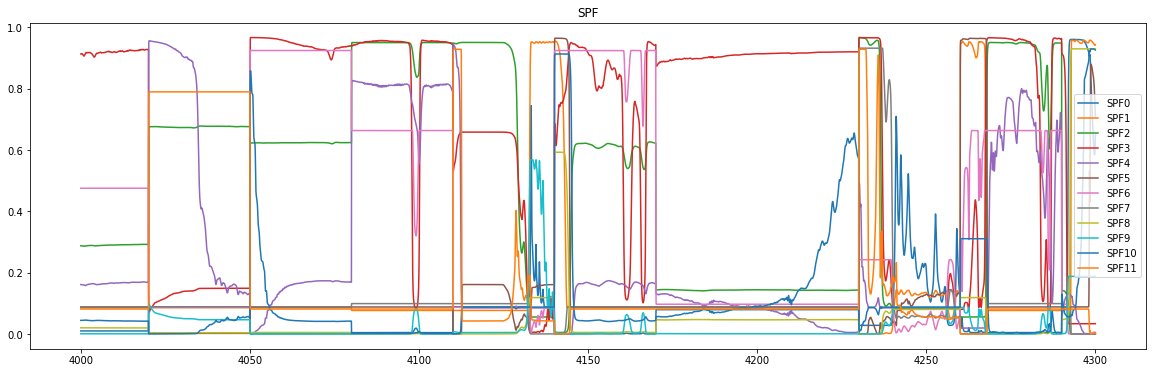

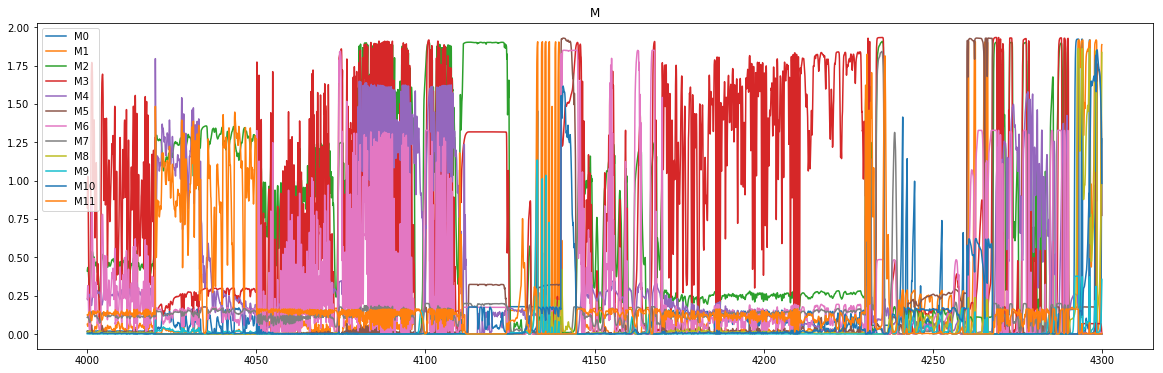

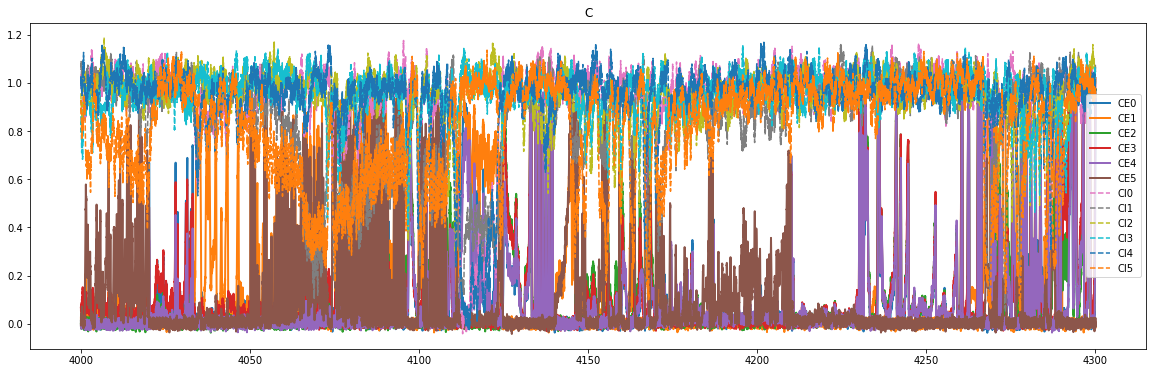

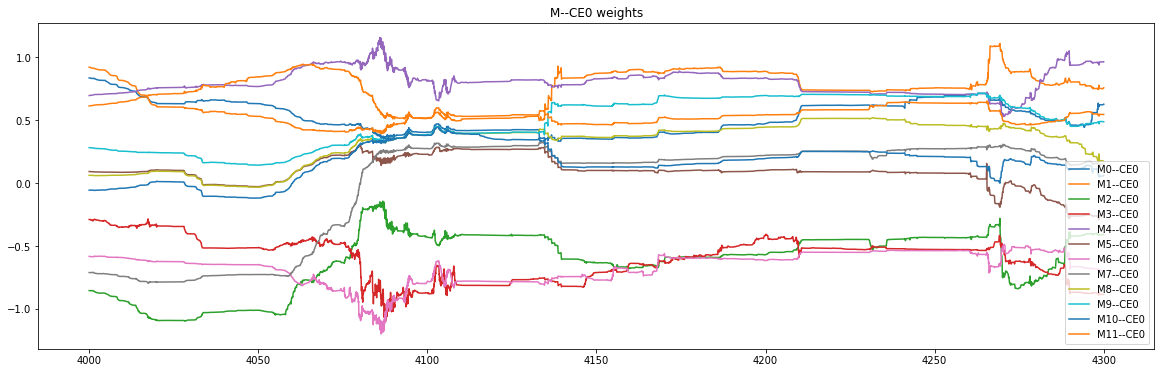

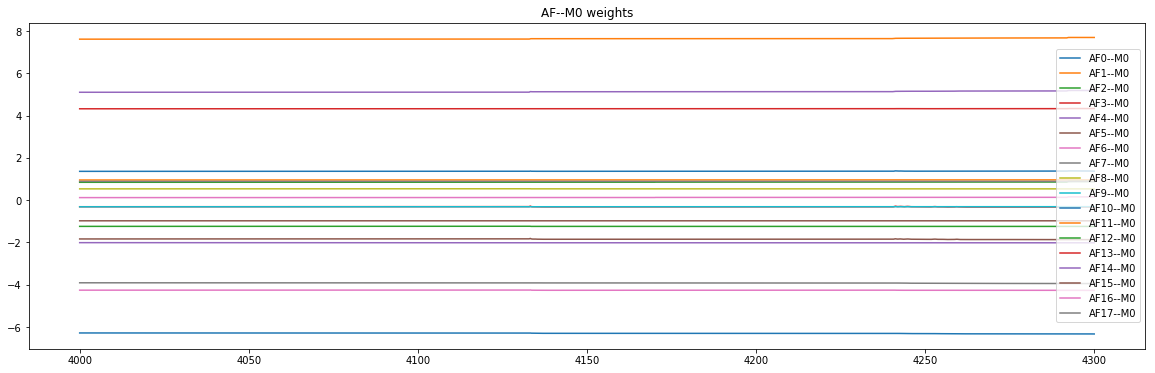

In [15]:
arm_activs = plant_data[P]
# SPF
fs = (20,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
SPF_legends = ['SPF'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends)
plt.title('SPF')
print(SPF_data[:,-1])

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
M_legends = ['M'+str(i) for i in range(len(M))]
plt.legend(M_legends)
plt.title('M')
print(M_data[:,-1])

# C
C_fig = plt.figure(figsize=fs)
CE_data = np.array(data[CE])
CI_data = np.array(data[CI])
plt.plot(times, CE_data.transpose(), linewidth=2)
plt.plot(times, CI_data.transpose(), '--')
C_legends = ['CE'+str(i) for i in range(len(CE))]
C_legends += ['CI'+str(i) for i in range(len(CI))]
plt.legend(C_legends)
plt.title('C')

# M--CE0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_CE_track])
plt.plot(times, w_track_data.transpose())
M_CE0_legends = ['M'+str(i)+'--CE0' for i in range(len(M_CE_track))]
plt.legend(M_CE0_legends)
plt.title('M--CE0 weights')

# AF--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[AF_M0_track])
plt.plot(times, w_track_data2.transpose())
AF_M0_legends = ['AF'+str(i)+'--M0' for i in range(len(AF_M0_track))]
plt.legend(AF_M0_legends)
plt.title('AF--M0 weights')

plt.show()

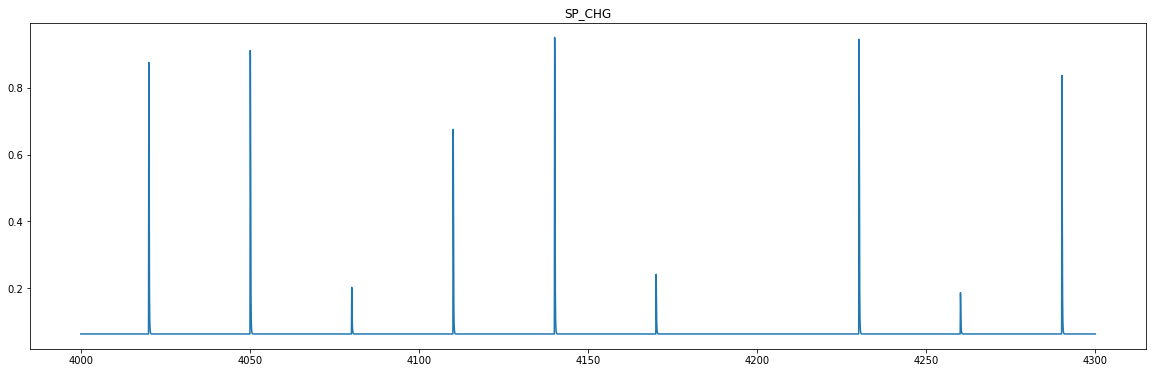

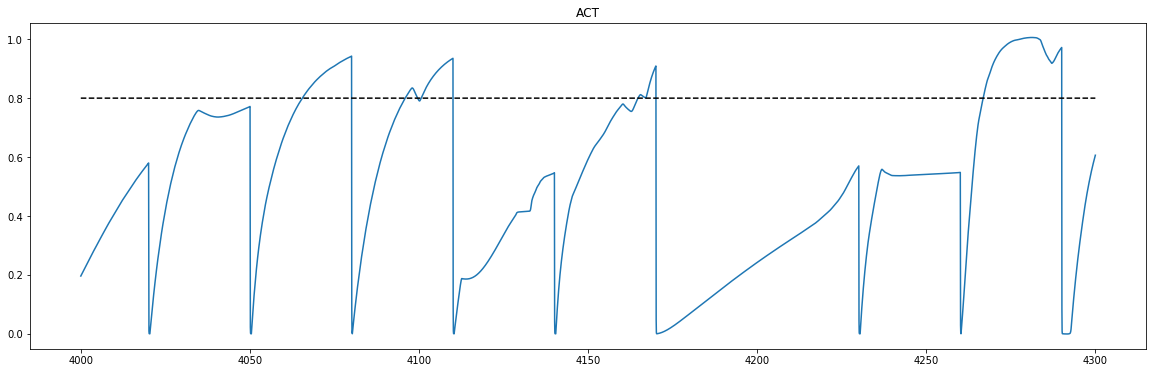

In [16]:
chg_fig = plt.figure(figsize=fs)
chg_data = np.array(data[SP_CHG])[0]
plt.plot(times, chg_data)
plt.title('SP_CHG')

act_fig = plt.figure(figsize=fs)
act_data = np.array(data[ACT])[0]
plt.plot(times, act_data)
plt.plot(times, 0.8*np.ones_like(times), 'k--')

plt.title('ACT')
plt.show()

shoulder angle: -0.218814, shoulder vel: -0.400277
AF_data:
[3.88216500e-001 2.39433488e-001 3.03755655e-037 6.50159492e-001
 2.49479962e-001 1.82385517e-219 5.50161408e-161 1.54765958e-003
 4.56229786e-037 3.18747872e-184 4.39208453e-004 1.14981410e-001
 2.06010537e-002 1.13438857e-001 1.41811947e-035 3.75969076e-001
 7.68264157e-002 1.61736882e-266]


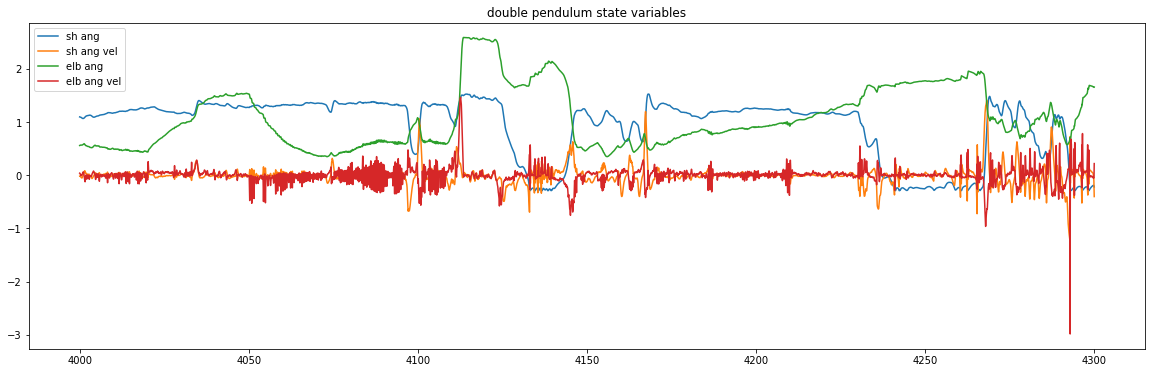

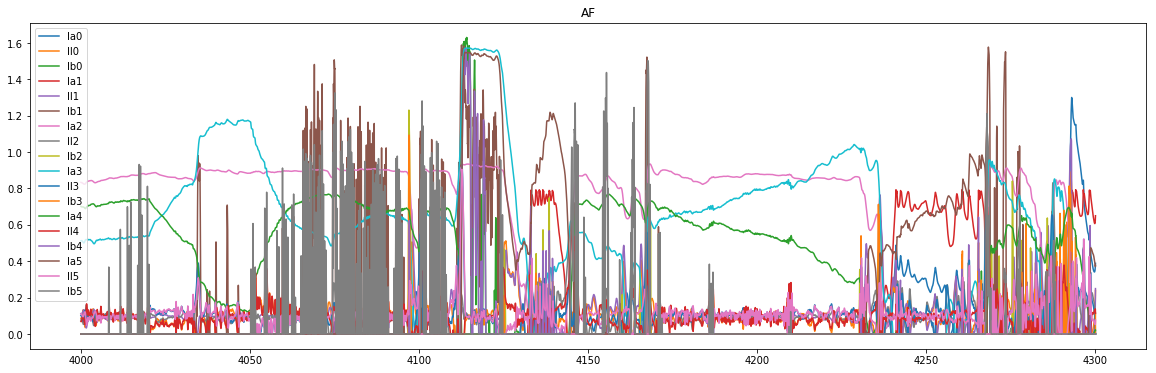

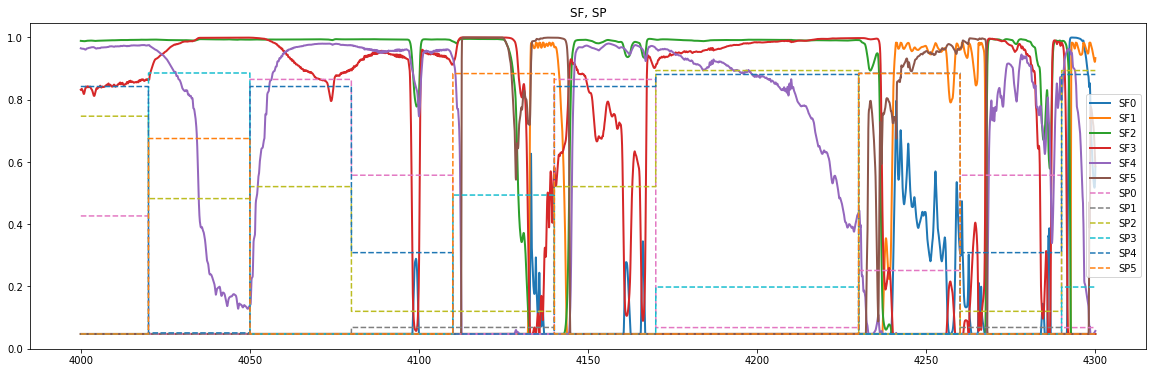

SF = 
[0.58289485 0.93371562 0.04742587 0.04742587 0.05711923 0.58641634]
SP = 
[0.06797516 0.04742587 0.89370035 0.19824297 0.88110376 0.04742587]


In [17]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4]
plt.plot(times, P_state)
plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.title('double pendulum state variables')
print("shoulder angle: %f, shoulder vel: %f" % (P_state[-1,0],P_state[-1,1]))

# AF
AF_fig = plt.figure(figsize=fs)
AF_data = np.array(data[AF])
plt.plot(times, AF_data.transpose())
li = [['Ia'+ str(i), 'II' + str(i), 'Ib' + str(i)] for i in range(int(len(AF)/3))]
AF_legends = []
for l in li: AF_legends += l
plt.legend(AF_legends)
plt.title('AF')
print('AF_data:')
print(AF_data[:,-1])

# SF, SP
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), linewidth=2)
plt.plot(times, SP_data.transpose(), '--')
SF_legends = ['SF'+str(i) for i in range(len(SF))]
SP_legends = ['SP'+str(i) for i in range(len(SP))]
plt.legend(SF_legends+SP_legends)
plt.title('SF, SP')
plt.show()
print('SF = ')
print(SF_data[:,-1])
print('SP = ')
print(SP_data[:,-1])

X=0


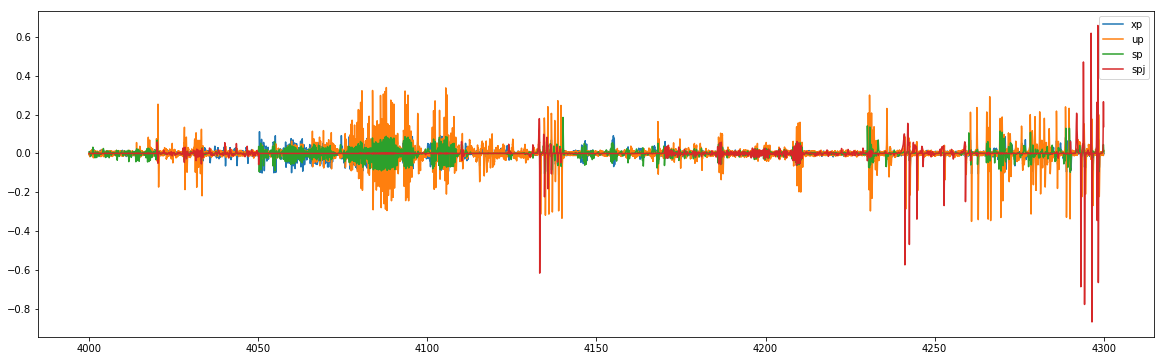

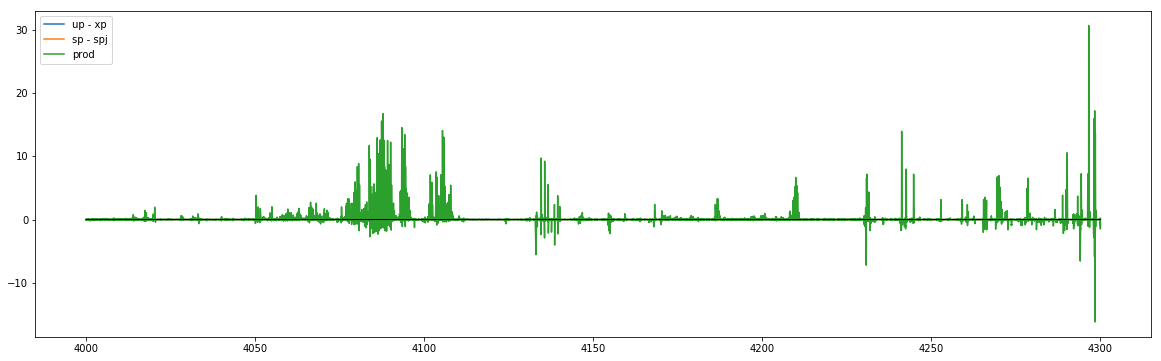

In [18]:
# plot all factors in the MX--C0 synaptic plasticity
print('X=%d' % (X))
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

AL_data:
[0.32160631 0.06549747 0.32326806 0.34468378 0.326934   0.0817261 ]


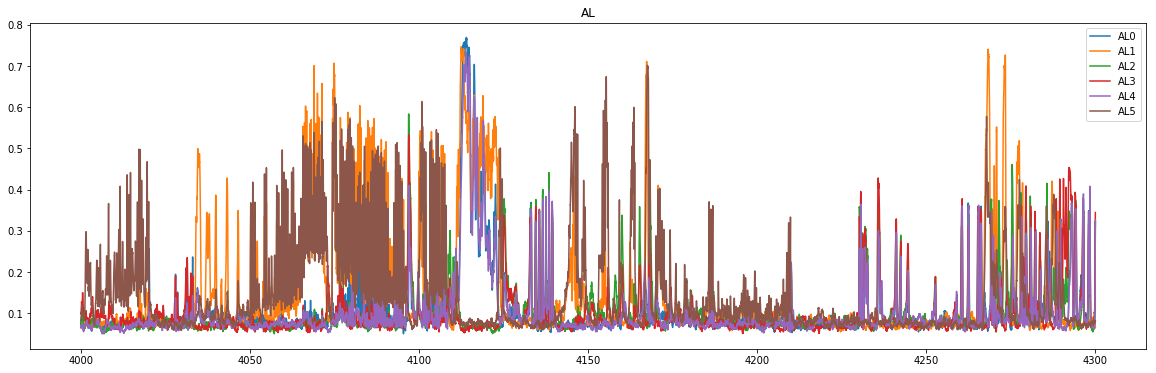

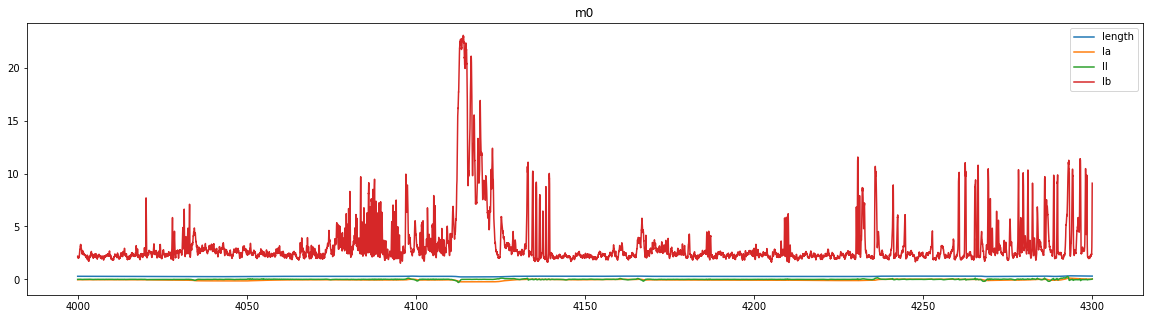

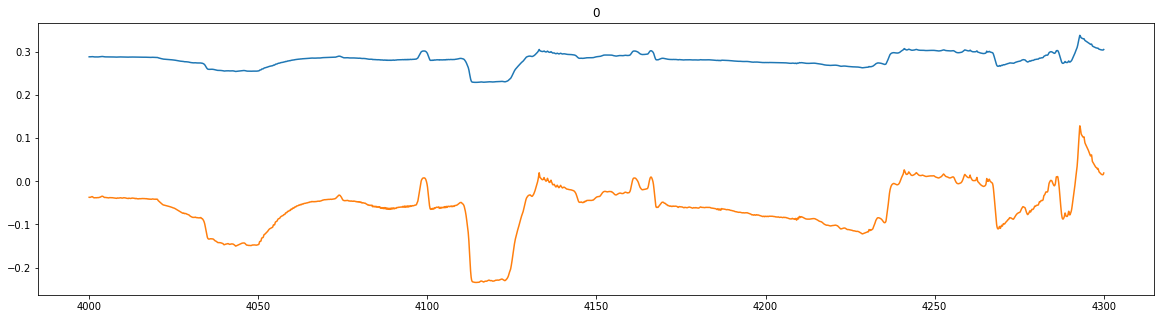

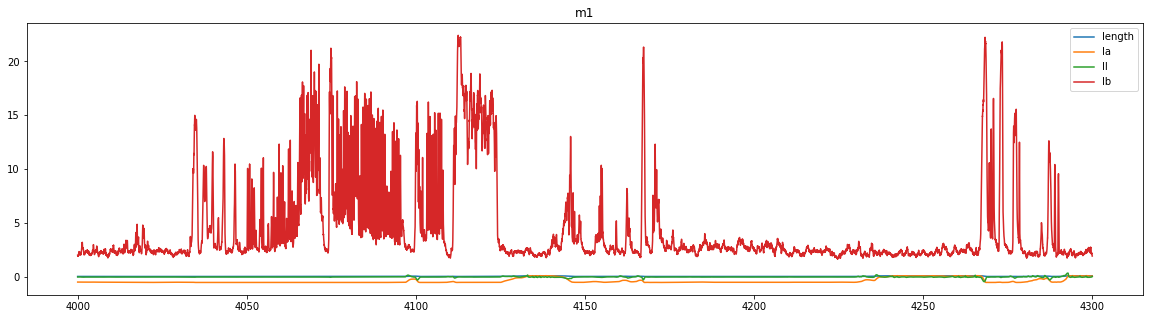

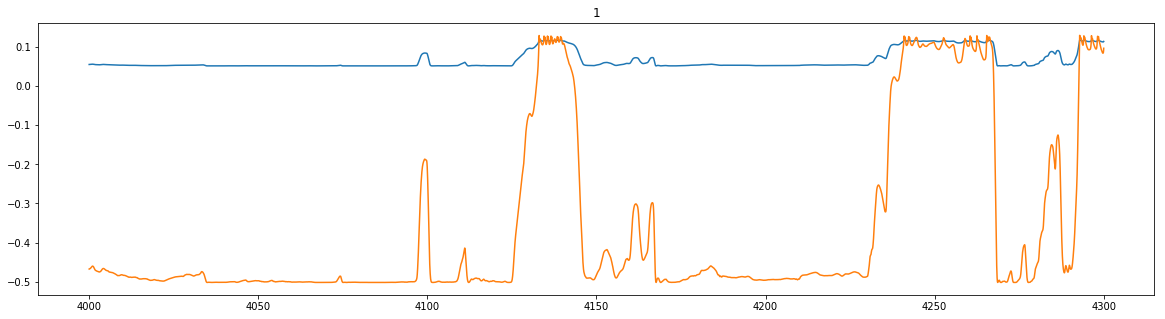

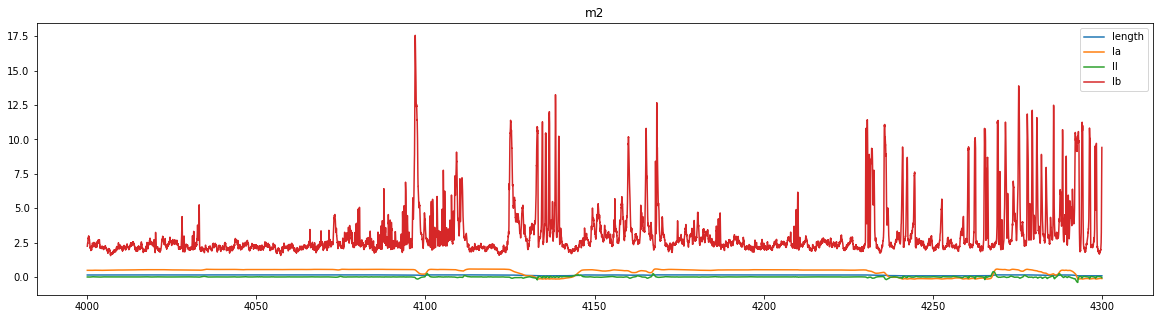

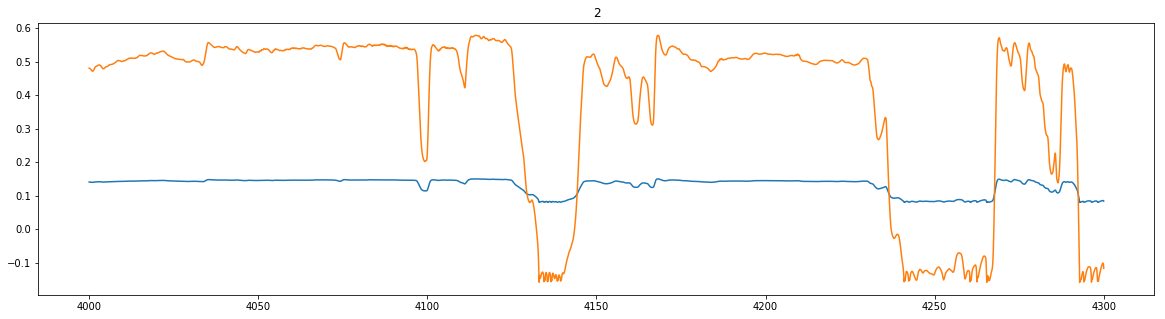

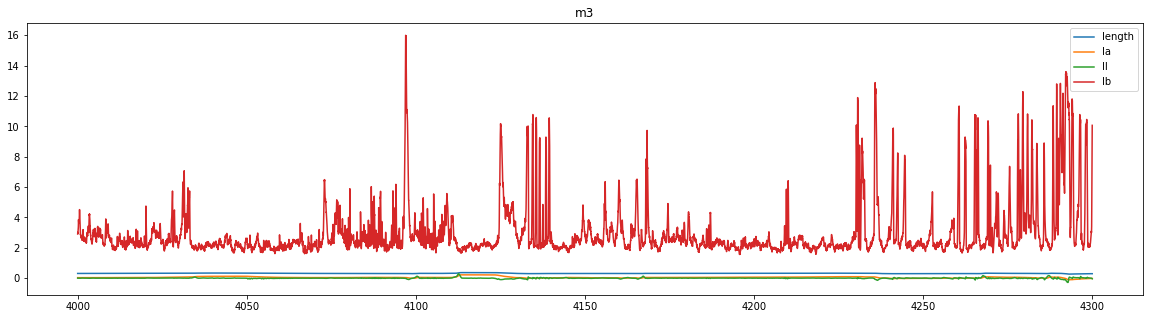

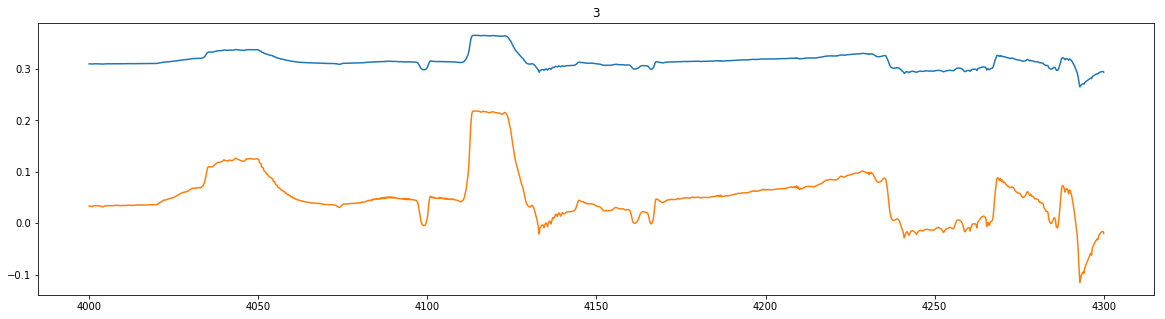

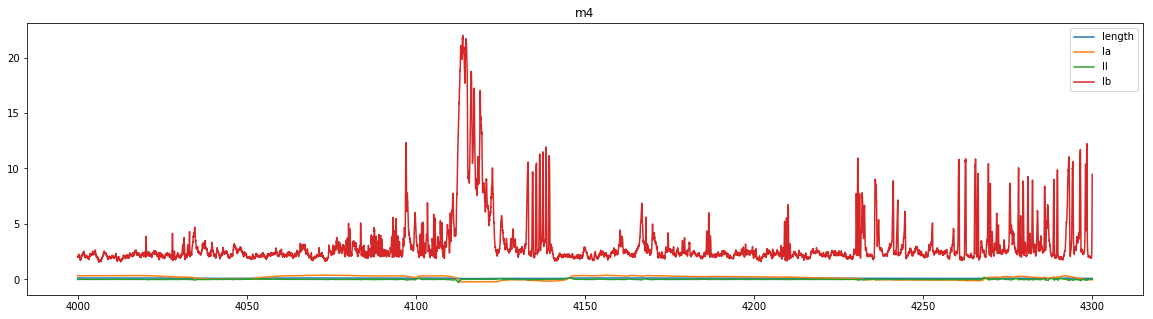

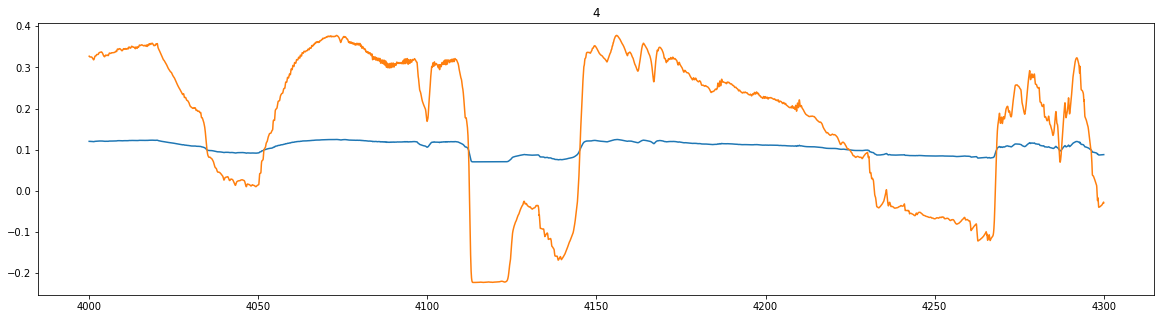

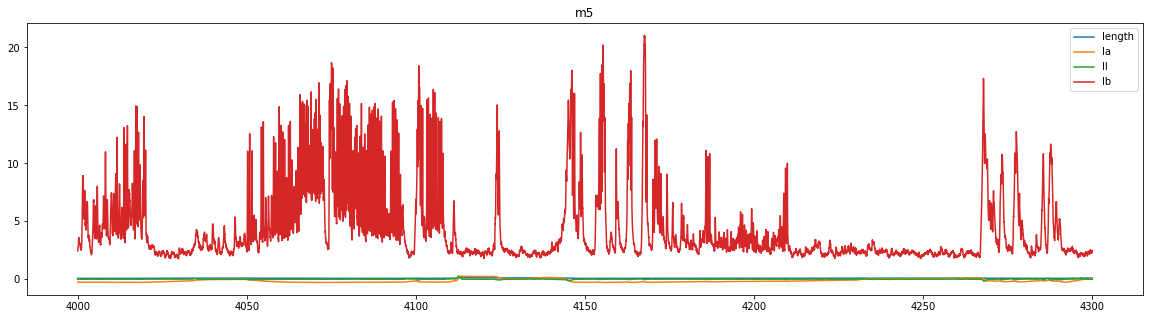

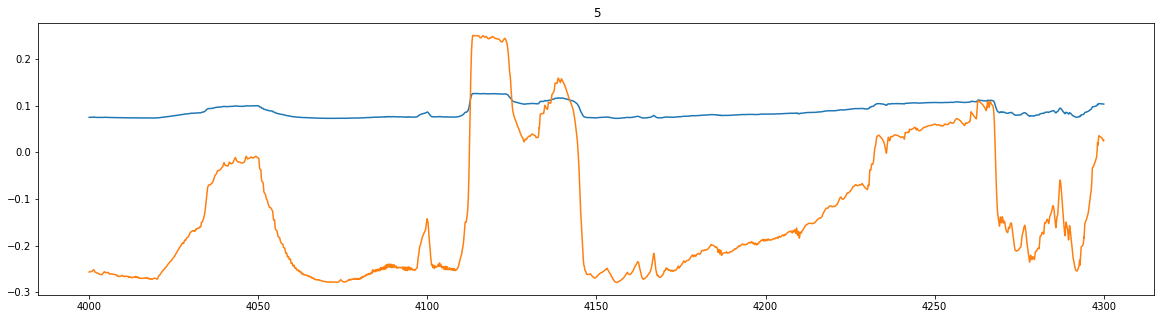

In [19]:
# Alpha units
AL_fig = plt.figure(figsize=fs)
AL_data = np.array(data[AL])
plt.plot(times, AL_data.transpose())
li = [['Ia'+ str(i), 'II' + str(i), 'Ib' + str(i)] for i in range(int(len(AF)/3))]
AL_legends = ['AL'+str(i) for i in range(len(AL))]
plt.legend(AL_legends)
plt.title('AL')
print('AL_data:')
print(AL_data[:,-1])

# plotting muscle outputs
fs = (20,5)
legs = ['length', 'Ia', 'II', 'Ib']

for i in range(6):
    next_fig = plt.figure(figsize=fs)
    affs = arm_activs[:,4+4*i:8+4*i]
    lens = arm_activs[:,4+4*i:6+4*i]
    plt.plot(times, affs)
    plt.legend(legs)
    plt.title('m' + str(i))
    plt.figure(figsize=fs)
    plt.plot(times, lens)
    plt.title(str(i))
plt.show()

In [20]:
# checking some connections
print("Connections to motor units")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[AF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to spinal units")
for idx, syn in enumerate(net.syns[CE[2]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CE, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")

for idx, syn in enumerate(net.syns[CI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CI, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")


print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in AL:
        pre_pop = 'AL'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
print("-------------------------\n")

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

Connections to motor units
0) AF (30) --> M, w=1.372231, port=0, plant_out=None
1) AF (31) --> M, w=7.694924, port=0, plant_out=None
2) AF (32) --> M, w=-1.240744, port=0, plant_out=None
3) AF (33) --> M, w=-0.342566, port=0, plant_out=None
4) AF (34) --> M, w=5.187606, port=0, plant_out=None
5) AF (35) --> M, w=-0.975650, port=0, plant_out=None
6) AF (36) --> M, w=0.157034, port=0, plant_out=None
7) AF (37) --> M, w=-3.942683, port=0, plant_out=None
8) AF (38) --> M, w=0.534962, port=0, plant_out=None
9) AF (39) --> M, w=-0.307921, port=0, plant_out=None
10) AF (40) --> M, w=-6.327428, port=0, plant_out=None
11) AF (41) --> M, w=0.959025, port=0, plant_out=None
12) AF (42) --> M, w=0.884159, port=0, plant_out=None
13) AF (43) --> M, w=4.332543, port=0, plant_out=None
14) AF (44) --> M, w=-2.015637, port=0, plant_out=None
15) AF (45) --> M, w=-1.872200, port=0, plant_out=None
16) AF (46) --> M, w=-4.267074, port=0, plant_out=None
17) AF (47) --> M, w=0.888487, port=0, plant_out=None
18

---

In [21]:
#Animation of the arm and muscles
%matplotlib widget
from numpy import cos, sin
from matplotlib.animation import FuncAnimation

# angles of shoulder and elbow
theta_s = arm_activs[:,0]
theta_e = arm_activs[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
acts = np.array(data[1])
ipx = data[ipx_track]
ipy = data[ipy_track]
ten = arm_activs[:, np.array(range(7, 28, 4))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2
# creating the figure and axis
fig = plt.figure(figsize=(8,8))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.grid()
# creating lines and points
line, = ax.plot([], [], 'o-b', lw=2)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
# preparing a colormap for the tensions
ten_max = max(ten.max(), 1e-5)
ten_min = min(ten.min(), -1e-5)
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
strt_idx = int(np.round(times[0]/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = frame*net.min_delay
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    # plotting target
    cur_idx = int(cur_time/t_pres) + strt_idx
    x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
    target.set_data([x_coord], [y_coord])
    
    return line, points, mus_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 10), init_func=init, blit=True, interval=10)

plt.show()

FigureCanvasNbAgg()

In [46]:
# Cell used to adjust parameters affecting the range of SF values
# corresponding to the various targets
muscl = 0
# lengths, as reported by the muscle (e.g. relative to l0)
len_vals = m_lengths[:, muscl]
min_len = min(len_vals)
max_len = max(len_vals)
mean_len = np.mean(len_vals)
print('length for muscle %d: min=%f, max=%f, mean=%f' % (muscl, min_len, max_len, mean_len))
print('length spread = %f' %(max_len - min_len))

# next, these normalized lenghts are transformed into arguments to the log:
# arg = w*len - thresh
# and then into the output of the afferent units:
# aff = log(1 + max(0, arg))
# we want to adjust P__AF_syn['init_w'] and AF_params['thresh'] so:
# 1) len = -0.5  is mapped to roughly arg=0, so aff=0
# 2) len = mean_len value is mapped to roughly arg = 0.65, so aff=0.5
# This implies equations:
# 0    = -0.5w - thresh
# 0.65 =  ml*w - thresh
# Thus: 0.65 = (ml+0.5)*w; w = 0.65/(ml+0.5); thresh = -w/2

w = 0.65/(mean_len + 0.5)
thresh = -w/2.
print("Recommended P__AF_syn['init_w']: %f" %(w))
print("Recommended AF_params['thresh']: %f" %(thresh))

# In a second criterion, we adjust P__AF_syn['init_w'] and AF_params['thresh'] so:
# 1) len = mean_len is mapped to roughly arg=0, so aff=0
# 2) len = (max_mean) is mapped roughly to arg=.65, so aff=0.5
# This implies equations
# 0 = mean_len*w  - thresh
# .65 = max_len*w - thresh
w = .65/(max_len - mean_len)
thresh = mean_len * w
print("Second recommended P__AF_syn['init_w']: %f" %(w))
print("Second recommended AF_params['thresh']: %f" %(thresh))

print('------------')

# In a third criterion, we adjust P__AF_syn['init_w'] and AF_params['thresh'] so:
# 1) len = l0 is mapped to roughly arg=0, so aff=0. Simply P__AF_syn['init_w']=0.
# 2) len = (max_mean) is mapped roughly to arg=.65, so aff=0.5
# This implies the equation
# .65 = max_len*w - thresh
thresh = 0.
w = .65/max_len
print("Third recommended P__AF_syn['init_w']: %f" %(w))
print("Third recommended AF_params['thresh']: %f" %(thresh))

print('------------')

arg_vals = l_arg[:, muscl]
min_arg = min(arg_vals)
max_arg = max(arg_vals)
mean_arg = np.mean(arg_vals)
print('arg for muscle %d: min=%f, max=%f, mean=%f' % (muscl, min_arg, max_arg, mean_arg))
print('arg spread = %f' %(max_arg - min_arg))

aff_vals = l_affs[:, muscl]
min_aff = min(aff_vals)
max_aff = max(aff_vals)
mean_aff = np.mean(aff_vals)
print('affs for muscle %d: min=%f, max=%f, mean=%f' % (muscl, min_aff, max_aff, mean_aff))
print('aff spread = %f' %(max_aff - min_aff))

print('------------')
# Next we want the  mean_aff value to produce sp output of roughly 0.5,
# and we want an sp spread of roughly 0.6 .
# This implies SF_params['thresh'] ~= 0.5*AF__SF_syn['init_w'], 
# and a SF_params['slope'] = s such that
# sig(max_aff) - sig(min_aff) = 0.6, so
# 1/(1+exp(-s*(max_aff-thr))) - 1/(1+exp(-s(min_aff-thr))) = 0.6

# For the second criterion min_aff is always 0, but mean_aff changes
# SF_params['thresh'] = AF__SF_syn['init_w']*mean_aff
# 1/(1+exp(-slope*(max_aff-thr))) - 1/(1+exp(slope*thr)) = 0.6

sp_vals = sf_preds[:,muscl]
min_sp = min(sp_vals)
max_sp = max(sp_vals)
mean_sp = np.mean(sp_vals)
print('SP for muscle %d: min=%f, max=%f, mean=%f' % (muscl, min_sp, max_sp, mean_sp))
print('sp spread = %f' %(max_sp - min_sp))

length for muscle 0: min=-0.038786, max=0.030794, mean=-0.001755
length spread = 0.069580
Recommended P__AF_syn['init_w']: 1.304580
Recommended AF_params['thresh']: -0.652290
Second recommended P__AF_syn['init_w']: 19.969378
Second recommended AF_params['thresh']: -0.035055
------------
Third recommended P__AF_syn['init_w']: 21.107719
Third recommended AF_params['thresh']: 0.000000
------------
arg for muscle 0: min=-0.775712, max=0.615888, mean=-0.035108
arg spread = 1.391601
affs for muscle 0: min=0.000000, max=0.479885, mean=0.139718
aff spread = 0.479885
------------
SP for muscle 0: min=0.047426, max=0.789009, mean=0.222771
sp spread = 0.741583


In [29]:
sf_preds[:,3]

array([0.06808263, 0.02297737, 0.02297737, 0.02297737, 0.02297737,
       0.3658014 , 0.92608844, 0.5331581 ])

In [31]:
AF__SF_syn['init_w']

[4.0, 3.0, 3.0, 5.0, 3.0, 3.0]